In [1]:
import pandas as pd
from pandas import to_datetime

df = pd.read_csv('../transaction_data_version3.csv')
product_df = pd.read_csv('../product.csv')
product_df1 = product_df[['PRODUCT_ID','SUB_COMMODITY_DESC']]
df_merge = df.merge(product_df1,on='PRODUCT_ID')
df_merge.groupby('SUB_COMMODITY_DESC')['QUANTITY'].sum().sort_values()
df_milk = df_merge.query('SUB_COMMODITY_DESC == "FLUID MILK WHITE ONLY"')
df_milk_1 = df_milk[['DATE','QUANTITY']]
df_milk_1 = df_milk_1.groupby('DATE')['QUANTITY'].sum().reset_index()
df_milk_1['DATE']= to_datetime(df_milk_1['DATE'])
df_milk_1['DATE'] = df_milk_1['DATE'].dt.strftime('%Y-%m-%d')
df_milk_1 = df_milk_1.groupby('DATE')['QUANTITY'].sum().reset_index()
df_milk_1

,DATE,QUANTITY
0,2019-07-30,2
1,2019-07-31,6
2,2019-08-01,13
3,2019-08-02,13
4,2019-08-03,8
...,...,...
704,2021-07-05,94
705,2021-07-06,104
706,2021-07-07,107
707,2021-07-08,108


In [2]:
df_milk_1.columns = ['date','sales']

In [3]:
df_milk_1.to_csv('../時間序列分析/monthly_data.csv',index=False)

In [4]:
monthly_data = df_milk_1.copy()

In [5]:
# Calculate difference in sales month over month
def get_diff(data):
    data['sales_diff'] = data.sales.diff()    
    data = data.dropna()      
    return data
stationary_df = get_diff(monthly_data)

In [6]:
stationary_df

,date,sales,sales_diff
1,2019-07-31,6,4.0
2,2019-08-01,13,7.0
3,2019-08-02,13,0.0
4,2019-08-03,8,-5.0
5,2019-08-04,10,2.0
...,...,...,...
704,2021-07-05,94,-8.0
705,2021-07-06,104,10.0
706,2021-07-07,107,3.0
707,2021-07-08,108,1.0


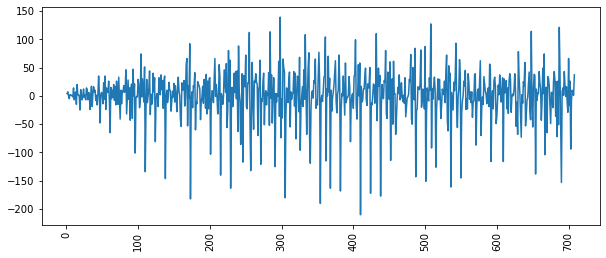

In [7]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10, 4))
plt.plot(stationary_df.index,stationary_df.sales_diff)
plt.xticks(rotation=90)
plt.show()

In [8]:
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,13):
        col = 'lag_' + str(i)
        supervised_df[col] = supervised_df['sales_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    supervised_df.to_csv('../時間序列分析/model_df.csv', index=False)
    
    return supervised_df
model_df = generate_supervised(stationary_df)

In [9]:
model_df

,date,sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2019-08-12,29,7.0,4.0,-7.0,14.0,-2.0,0.0,1.0,2.0,2.0,-5.0,0.0,7.0,4.0
1,2019-08-13,14,-15.0,7.0,4.0,-7.0,14.0,-2.0,0.0,1.0,2.0,2.0,-5.0,0.0,7.0
2,2019-08-14,34,20.0,-15.0,7.0,4.0,-7.0,14.0,-2.0,0.0,1.0,2.0,2.0,-5.0,0.0
3,2019-08-15,36,2.0,20.0,-15.0,7.0,4.0,-7.0,14.0,-2.0,0.0,1.0,2.0,2.0,-5.0
4,2019-08-16,38,2.0,2.0,20.0,-15.0,7.0,4.0,-7.0,14.0,-2.0,0.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,2021-07-05,94,-8.0,-94.0,26.0,-17.0,66.0,-29.0,-11.0,16.0,-1.0,18.0,43.0,1.0,14.0
692,2021-07-06,104,10.0,-8.0,-94.0,26.0,-17.0,66.0,-29.0,-11.0,16.0,-1.0,18.0,43.0,1.0
693,2021-07-07,107,3.0,10.0,-8.0,-94.0,26.0,-17.0,66.0,-29.0,-11.0,16.0,-1.0,18.0,43.0
694,2021-07-08,108,1.0,3.0,10.0,-8.0,-94.0,26.0,-17.0,66.0,-29.0,-11.0,16.0,-1.0,18.0


In [48]:
def load_data(file_name):
    """Returns a pandas dataframe from a csv file."""
    return pd.read_csv(file_name)

def scale_data(train_set, test_set):
    """Scales data using MinMaxScaler and separates data into X_train, y_train,
    X_test, and y_test.
    Keyword Arguments:
    -- train_set: dataset used to train the model
    -- test_set: dataset used to test the model
    """

    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)

    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)

    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)

    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()

    return X_train, y_train, X_test, y_test, scaler



def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):
    """For visualizing and comparing results, undoes the scaling effect on
    predictions.
    Keyword arguments:
    -- y_pred: model predictions
    -- x_test: features from the test set used for predictions
    -- scaler_obj: the scaler objects used for min-max scaling
    -- lstm: indicate if the model run is the lstm. If True, additional
             transformation occurs
    """

    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)

    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0, len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index], x_test[index]],
                                            axis=1))

    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0],
                                          pred_test_set.shape[2])

    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)

    return pred_test_set_inverted


def predict_df(unscaled_predictions, original_df):
    """Generates a dataframe that shows the predicted sales for each month
    for plotting results.
    Keyword arguments:
    -- unscaled_predictions: the model predictions that do not have min-max or
                             other scaling applied
    -- original_df: the original monthly sales dataframe
    """
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)

    for index in range(0, len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] +
                                        act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)

    df_result = pd.DataFrame(result_list)

    return df_result

def get_scores(unscaled_df, original_df, model_name):
    """Prints the root mean squared error, mean absolute error, and r2 scores
    for each model. Saves all results in a model_scores dictionary for
    comparison.
    Keyword arguments:
    -- unscaled_predictions: the model predictions that do not have min-max or
                             other scaling applied
    -- original_df: the original monthly sales dataframe
    -- model_name: the name that will be used to store model scores
    """
    rmse = np.sqrt(mean_squared_error(original_df.sales[-12:], unscaled_df.pred_value[-12:]))
    mse = mean_squared_error(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    mae = mean_absolute_error(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    r2 = r2_score(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [mse,rmse, mae, r2]
    
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    
def regressive_model(train_data, test_data, model, model_name):
    
    # Call helper functions to create X & y and scale data
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    # Run regression model
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    # Call helper functions to undo scaling & create prediction df
    original_df = load_data('../時間序列分析/monthly_data.csv')
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
    # Call helper functions to print scores and plot results
    get_scores(unscaled_df, original_df, model_name)
    plot_results(unscaled_df, original_df, model_name)
    
def tts(data):
    """Splits the data into train and test. Test set consists of the last 12
    months of data.
    """
    data = data.drop(['sales', 'date'], axis=1)
    train, test = data[0:-12].values, data[-12:].values

    return train, test


def plot_results(results, original_df, model_name):
    """Plots predictions over original data to visualize results. Saves each
    plot as a png.
    Keyword arguments:
    -- results: a dataframe with unscaled predictions
    -- original_df: the original monthly sales dataframe
    -- model_name: the name that will be used in the plot title
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax,
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax,
                 label='Predicted', color='red')
    x_major_locator = MultipleLocator()
    ax.xaxis.set_major_locator(x_major_locator)
    ax.set(xlabel="Date",
           ylabel="Sales",
           title=f"{model_name} Sales Forecasting Prediction")
    ax.legend()
    sns.despine()

    plt.savefig(f'../時間序列分析/{model_name}_forecast.png')


In [50]:
# Separate data into train and test sets
train, test = tts(model_df)

MSE: 479.3333333333333
RMSE: 21.8936824982307
MAE: 16.5
R2 Score: 0.590281776252916


C:\ProgramData\Anaconda3\envs\time_analyse\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\ProgramData\Anaconda3\envs\time_analyse\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


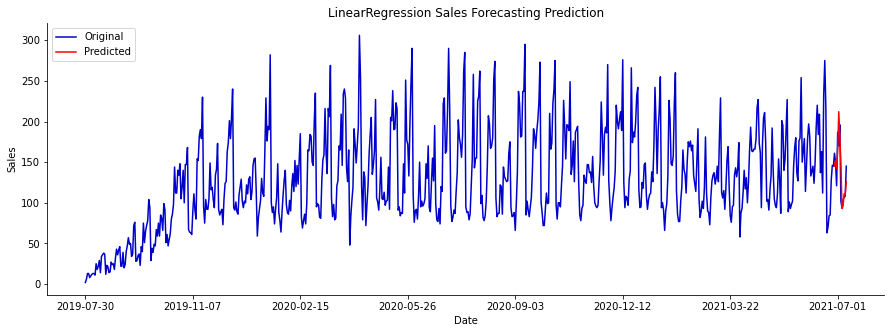

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import numpy as np
import seaborn as sns
from matplotlib.pyplot import MultipleLocator

model_scores = {}
# Call model frame work for linear regression
regressive_model(train, test, LinearRegression(),'LinearRegression')

MSE: 1069.5833333333333
RMSE: 32.70448491160399
MAE: 22.083333333333332
R2 Score: 0.08575566728201955


C:\ProgramData\Anaconda3\envs\time_analyse\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\ProgramData\Anaconda3\envs\time_analyse\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


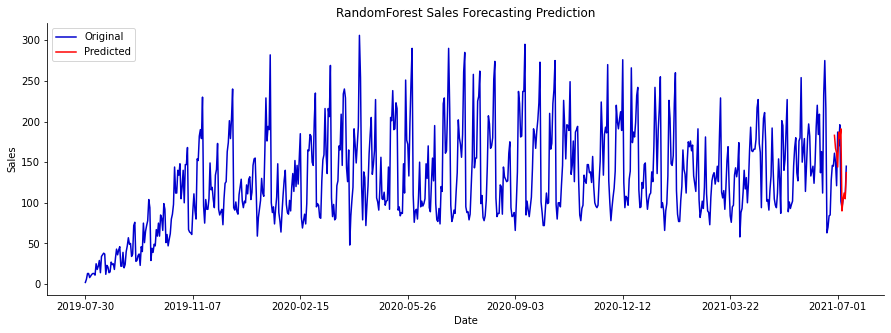

In [35]:
from sklearn.ensemble import RandomForestRegressor

# Call model frame work for random forest regressor 
regressive_model(train, test, 
                 RandomForestRegressor(n_estimators=100,
                                       max_depth=20),        
                                       'RandomForest')

MSE: 1063.0
RMSE: 32.60368077380221
MAE: 22.166666666666668
R2 Score: 0.09138288210747503


C:\ProgramData\Anaconda3\envs\time_analyse\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\ProgramData\Anaconda3\envs\time_analyse\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


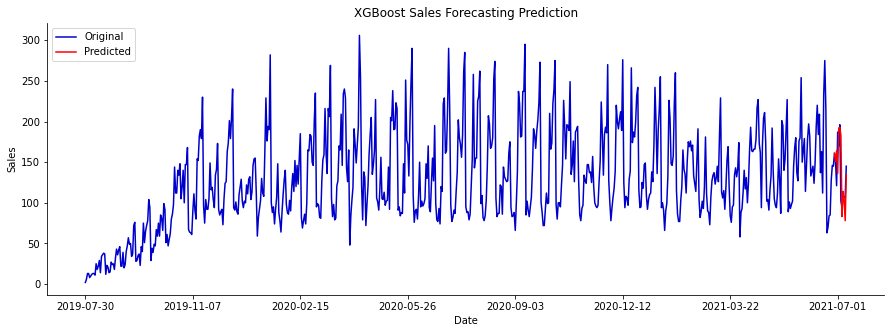

In [36]:
from xgboost.sklearn import XGBRegressor

# Call model frame work for XGBoost
regressive_model(train, test, XGBRegressor(n_estimators=100,
                                           learning_rate=0.2), 
                                           'XGBoost')

In [15]:
import pickle
pickle.dump(model_scores, open("model_scores.p", "wb"))

In [17]:
def create_results_df():
    # Load pickled scores for each model
    results_dict = pickle.load(open("model_scores.p", "rb"))
    # Create pandas df 
    results_df = pd.DataFrame.from_dict(results_dict, 
                    orient='index', columns=['MSE','RMSE', 'MAE', 'R2'])
    results_df = results_df.sort_values(by='RMSE',
                     ascending=False).reset_index()
    return results_df
results = create_results_df()

In [18]:
results_dict = pickle.load(open("model_scores.p", "rb"))

In [19]:
results

,index,MSE,RMSE,MAE,R2
0,RandomForest,1133.666667,33.669967,23.666667,0.030979
1,XGBoost,1063.000000,32.603681,22.166667,0.091383
2,LinearRegression,479.333333,21.893682,16.500000,0.590282
